In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot

%matplotlib inline

import optuna 
import math
import seaborn as sns
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

import xgboost as xgb
import lightgbm as lgb

In [2]:
adidas_final_df = pd.read_csv('../data_preprocessing/adidas_final_df.csv')
text_df_256 = pd.read_csv('../data/text_features/text_df_256.csv')
img_xception_256_df = pd.read_csv('../data/img_features/img_xception_256_df.csv')

#### テキストと画像の特徴量名を変更

In [3]:
text_df_256

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.012589,0.011602,0.001393,0.024053,0.0,0.043073,0.007888,0.027093,...,0.0,0.054930,0.014631,0.0,0.023574,0.045781,0.0,0.0,0.015947,0.002259
1,0.0,0.0,0.021740,0.013706,0.000000,0.017139,0.0,0.050353,0.014417,0.025105,...,0.0,0.055210,0.015369,0.0,0.017529,0.033443,0.0,0.0,0.017639,0.003152
2,0.0,0.0,0.014911,0.011960,0.004514,0.023058,0.0,0.031543,0.008051,0.019397,...,0.0,0.052308,0.010773,0.0,0.014470,0.027584,0.0,0.0,0.007615,0.010024
3,0.0,0.0,0.010309,0.021024,0.004183,0.008392,0.0,0.048715,0.006296,0.024035,...,0.0,0.045357,0.018151,0.0,0.017598,0.031712,0.0,0.0,0.013940,0.007207
4,0.0,0.0,0.011550,0.018449,0.008756,0.028109,0.0,0.047686,0.010374,0.030370,...,0.0,0.064967,0.015366,0.0,0.016728,0.031528,0.0,0.0,0.015743,0.000937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,0.0,0.0,0.017880,0.011480,0.000000,0.031377,0.0,0.052509,0.013127,0.021174,...,0.0,0.053601,0.009422,0.0,0.022746,0.042807,0.0,0.0,0.000000,0.005116
3848,0.0,0.0,0.021002,0.010189,0.004985,0.031378,0.0,0.049586,0.004048,0.020270,...,0.0,0.058208,0.013774,0.0,0.019924,0.049637,0.0,0.0,0.011541,0.006723
3849,0.0,0.0,0.005070,0.012232,0.002949,0.024441,0.0,0.039581,0.002306,0.025361,...,0.0,0.055463,0.002061,0.0,0.021807,0.028284,0.0,0.0,0.008126,0.000000
3850,0.0,0.0,0.031992,0.010909,0.000000,0.032330,0.0,0.042308,0.009438,0.016021,...,0.0,0.064246,0.019134,0.0,0.014014,0.043467,0.0,0.0,0.020839,0.009376


In [4]:
text_df_256.columns = list('text' + str(i) for i in range(len(text_df_256.columns)))
text_df_256

,text0,text1,text2,text3,text4,text5,text6,text7,text8,text9,...,text246,text247,text248,text249,text250,text251,text252,text253,text254,text255
0,0.0,0.0,0.012589,0.011602,0.001393,0.024053,0.0,0.043073,0.007888,0.027093,...,0.0,0.054930,0.014631,0.0,0.023574,0.045781,0.0,0.0,0.015947,0.002259
1,0.0,0.0,0.021740,0.013706,0.000000,0.017139,0.0,0.050353,0.014417,0.025105,...,0.0,0.055210,0.015369,0.0,0.017529,0.033443,0.0,0.0,0.017639,0.003152
2,0.0,0.0,0.014911,0.011960,0.004514,0.023058,0.0,0.031543,0.008051,0.019397,...,0.0,0.052308,0.010773,0.0,0.014470,0.027584,0.0,0.0,0.007615,0.010024
3,0.0,0.0,0.010309,0.021024,0.004183,0.008392,0.0,0.048715,0.006296,0.024035,...,0.0,0.045357,0.018151,0.0,0.017598,0.031712,0.0,0.0,0.013940,0.007207
4,0.0,0.0,0.011550,0.018449,0.008756,0.028109,0.0,0.047686,0.010374,0.030370,...,0.0,0.064967,0.015366,0.0,0.016728,0.031528,0.0,0.0,0.015743,0.000937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,0.0,0.0,0.017880,0.011480,0.000000,0.031377,0.0,0.052509,0.013127,0.021174,...,0.0,0.053601,0.009422,0.0,0.022746,0.042807,0.0,0.0,0.000000,0.005116
3848,0.0,0.0,0.021002,0.010189,0.004985,0.031378,0.0,0.049586,0.004048,0.020270,...,0.0,0.058208,0.013774,0.0,0.019924,0.049637,0.0,0.0,0.011541,0.006723
3849,0.0,0.0,0.005070,0.012232,0.002949,0.024441,0.0,0.039581,0.002306,0.025361,...,0.0,0.055463,0.002061,0.0,0.021807,0.028284,0.0,0.0,0.008126,0.000000
3850,0.0,0.0,0.031992,0.010909,0.000000,0.032330,0.0,0.042308,0.009438,0.016021,...,0.0,0.064246,0.019134,0.0,0.014014,0.043467,0.0,0.0,0.020839,0.009376


In [5]:
img_xception_256_df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-4.283783,-6.750264,-5.150335,1.256626,-9.724740,-5.048487,7.188885,5.376353,3.990421,8.145538,...,-0.648935,-0.120583,1.153213,-0.128543,-0.920567,0.106602,0.111665,-2.549753,1.048322,0.201124
1,1.382455,-9.231929,-4.143682,0.357695,3.905091,2.579433,-8.553669,-10.803032,6.684401,1.794472,...,0.841444,-0.667306,0.074299,0.553337,-0.124056,0.731418,-0.216277,-0.123274,0.041337,0.570121
2,1.673768,-0.246558,-1.221280,-10.127142,-3.121317,0.519163,-2.679033,5.912999,-0.021313,-4.509241,...,-0.581684,-0.227046,-0.217118,0.119498,-0.278172,0.283073,0.291391,-0.727543,0.221040,0.448093
3,13.290643,-2.184021,-3.324477,2.637169,-4.675468,6.345741,-1.390021,12.048939,4.203515,-12.391635,...,0.074783,-0.413718,0.453913,0.389411,1.064384,0.098850,-0.513975,1.090405,-1.216707,0.127937
4,0.833021,-11.004178,13.292379,-3.163523,-1.757586,-0.528176,2.310873,-0.791523,-3.335037,2.362862,...,-0.094554,0.379446,-0.321235,0.124492,-0.233251,-0.139270,0.056734,-0.091511,-0.184895,-0.296739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,-2.439531,-3.670244,-6.734210,11.521386,0.397611,-1.654798,-2.403471,-0.727678,-1.244541,-4.762022,...,0.953534,-0.173254,-0.148228,0.625639,0.742523,0.705929,0.015177,-0.478576,0.481781,0.080437
3848,8.248449,12.790409,-7.766125,-10.269954,2.882046,3.910087,-6.728028,5.449539,-4.332220,-2.647355,...,-0.620082,-0.058535,0.328622,-0.200182,0.178651,-0.457069,0.075214,-0.205814,-0.133676,0.541402
3849,9.745172,6.925892,6.317610,-3.153733,0.767988,-10.826612,-9.771851,-6.034394,-9.890096,-2.011041,...,-0.982458,0.250265,0.141177,0.471650,0.088675,-1.203837,0.342324,0.275875,-0.444143,-0.801507
3850,-3.907735,-10.250506,4.323690,12.592658,3.593113,-5.303736,-5.119253,-6.489745,-2.811875,-9.672999,...,-0.582533,-0.115730,-0.018864,-1.070928,0.337022,0.671291,0.351281,0.580692,-1.223862,0.548533


In [6]:
img_xception_256_df.columns = list('img' + str(i) for i in range(len(img_xception_256_df.columns)))
img_xception_256_df

,img0,img1,img2,img3,img4,img5,img6,img7,img8,img9,...,img246,img247,img248,img249,img250,img251,img252,img253,img254,img255
0,-4.283783,-6.750264,-5.150335,1.256626,-9.724740,-5.048487,7.188885,5.376353,3.990421,8.145538,...,-0.648935,-0.120583,1.153213,-0.128543,-0.920567,0.106602,0.111665,-2.549753,1.048322,0.201124
1,1.382455,-9.231929,-4.143682,0.357695,3.905091,2.579433,-8.553669,-10.803032,6.684401,1.794472,...,0.841444,-0.667306,0.074299,0.553337,-0.124056,0.731418,-0.216277,-0.123274,0.041337,0.570121
2,1.673768,-0.246558,-1.221280,-10.127142,-3.121317,0.519163,-2.679033,5.912999,-0.021313,-4.509241,...,-0.581684,-0.227046,-0.217118,0.119498,-0.278172,0.283073,0.291391,-0.727543,0.221040,0.448093
3,13.290643,-2.184021,-3.324477,2.637169,-4.675468,6.345741,-1.390021,12.048939,4.203515,-12.391635,...,0.074783,-0.413718,0.453913,0.389411,1.064384,0.098850,-0.513975,1.090405,-1.216707,0.127937
4,0.833021,-11.004178,13.292379,-3.163523,-1.757586,-0.528176,2.310873,-0.791523,-3.335037,2.362862,...,-0.094554,0.379446,-0.321235,0.124492,-0.233251,-0.139270,0.056734,-0.091511,-0.184895,-0.296739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,-2.439531,-3.670244,-6.734210,11.521386,0.397611,-1.654798,-2.403471,-0.727678,-1.244541,-4.762022,...,0.953534,-0.173254,-0.148228,0.625639,0.742523,0.705929,0.015177,-0.478576,0.481781,0.080437
3848,8.248449,12.790409,-7.766125,-10.269954,2.882046,3.910087,-6.728028,5.449539,-4.332220,-2.647355,...,-0.620082,-0.058535,0.328622,-0.200182,0.178651,-0.457069,0.075214,-0.205814,-0.133676,0.541402
3849,9.745172,6.925892,6.317610,-3.153733,0.767988,-10.826612,-9.771851,-6.034394,-9.890096,-2.011041,...,-0.982458,0.250265,0.141177,0.471650,0.088675,-1.203837,0.342324,0.275875,-0.444143,-0.801507
3850,-3.907735,-10.250506,4.323690,12.592658,3.593113,-5.303736,-5.119253,-6.489745,-2.811875,-9.672999,...,-0.582533,-0.115730,-0.018864,-1.070928,0.337022,0.671291,0.351281,0.580692,-1.223862,0.548533


#### データを結合

In [7]:
df = pd.concat([adidas_final_df[['retail_price', 'avg_sale_price_12_month']], img_xception_256_df, text_df_256], axis=1)
df

,retail_price,avg_sale_price_12_month,img0,img1,img2,img3,img4,img5,img6,img7,...,text246,text247,text248,text249,text250,text251,text252,text253,text254,text255
0,57585.0,19300.0,-4.283783,-6.750264,-5.150335,1.256626,-9.724740,-5.048487,7.188885,5.376353,...,0.0,0.054930,0.014631,0.0,0.023574,0.045781,0.0,0.0,0.015947,0.002259
1,14134.5,20900.0,1.382455,-9.231929,-4.143682,0.357695,3.905091,2.579433,-8.553669,-10.803032,...,0.0,0.055210,0.015369,0.0,0.017529,0.033443,0.0,0.0,0.017639,0.003152
2,20940.0,22900.0,1.673768,-0.246558,-1.221280,-10.127142,-3.121317,0.519163,-2.679033,5.912999,...,0.0,0.052308,0.010773,0.0,0.014470,0.027584,0.0,0.0,0.007615,0.010024
3,16752.0,4700.0,13.290643,-2.184021,-3.324477,2.637169,-4.675468,6.345741,-1.390021,12.048939,...,0.0,0.045357,0.018151,0.0,0.017598,0.031712,0.0,0.0,0.013940,0.007207
4,18846.0,11000.0,0.833021,-11.004178,13.292379,-3.163523,-1.757586,-0.528176,2.310873,-0.791523,...,0.0,0.064967,0.015366,0.0,0.016728,0.031528,0.0,0.0,0.015743,0.000937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,12564.0,5400.0,-2.439531,-3.670244,-6.734210,11.521386,0.397611,-1.654798,-2.403471,-0.727678,...,0.0,0.053601,0.009422,0.0,0.022746,0.042807,0.0,0.0,0.000000,0.005116
3848,10470.0,8600.0,8.248449,12.790409,-7.766125,-10.269954,2.882046,3.910087,-6.728028,5.449539,...,0.0,0.058208,0.013774,0.0,0.019924,0.049637,0.0,0.0,0.011541,0.006723
3849,18846.0,19800.0,9.745172,6.925892,6.317610,-3.153733,0.767988,-10.826612,-9.771851,-6.034394,...,0.0,0.055463,0.002061,0.0,0.021807,0.028284,0.0,0.0,0.008126,0.000000
3850,18846.0,35900.0,-3.907735,-10.250506,4.323690,12.592658,3.593113,-5.303736,-5.119253,-6.489745,...,0.0,0.064246,0.019134,0.0,0.014014,0.043467,0.0,0.0,0.020839,0.009376


## 5クラス分類

#### 利益（リセール価格 - 定価）フラグを追加

- lv0 利益が-10000円未満
- lv1 利益が-10000円以上-2500円未満
- lv2 利益が-2500円以上2500未満
- lv3 利益が2500円以上10000円未満
- lv4 利益が10000円以上


この利益フラグを予測する多クラス分類とする。

In [8]:
#5クラス分類

df['profit'] = df['avg_sale_price_12_month'] - df['retail_price']

item0 = df[(df['profit'] < -10000)]
item1 = df[(df['profit'] >= -10000) & (df['profit'] < -2500)]
item2 = df[(df['profit'] >= -2500) & (df['profit'] < 2500)]
item3 = df[(df['profit'] >= 2500) & (df['profit'] < 10000)]
item4 = df[(df['profit'] >= 10000)]

print('-10000未満: {}個'.format(len(item0)))
print('-10000以上-2500未満: {}個'.format(len(item1)))
print('-2500以上-2500未満: {}個'.format(len(item2)))
print('2500以上10000未満: {}個'.format(len(item3)))
print('10000以上: {}個'.format(len(item4)))

df.loc[df['profit'] < -10000, 'profit_flg'] = 'lv0'
df.loc[(df['profit'] >= -10000) & (df['profit'] < -2500), 'profit_flg'] = 'lv1'
df.loc[(df['profit'] >= -2500) & (df['profit'] < 2500), 'profit_flg'] = 'lv2'
df.loc[(df['profit'] >= 2500) & (df['profit'] < 10000), 'profit_flg'] = 'lv3'
df.loc[df['profit'] >= 10000, 'profit_flg'] = 'lv4'

-10000未満: 472個
-10000以上-2500未満: 1724個
-2500以上-2500未満: 964個
2500以上10000未満: 450個
10000以上: 242個


データの約半分がlv1に属する、やや不均衡なクラス分布のデータセットである。

In [9]:
df = df.drop(['avg_sale_price_12_month', 'profit'], axis=1)
df

,retail_price,img0,img1,img2,img3,img4,img5,img6,img7,img8,...,text247,text248,text249,text250,text251,text252,text253,text254,text255,profit_flg
0,57585.0,-4.283783,-6.750264,-5.150335,1.256626,-9.724740,-5.048487,7.188885,5.376353,3.990421,...,0.054930,0.014631,0.0,0.023574,0.045781,0.0,0.0,0.015947,0.002259,lv0
1,14134.5,1.382455,-9.231929,-4.143682,0.357695,3.905091,2.579433,-8.553669,-10.803032,6.684401,...,0.055210,0.015369,0.0,0.017529,0.033443,0.0,0.0,0.017639,0.003152,lv3
2,20940.0,1.673768,-0.246558,-1.221280,-10.127142,-3.121317,0.519163,-2.679033,5.912999,-0.021313,...,0.052308,0.010773,0.0,0.014470,0.027584,0.0,0.0,0.007615,0.010024,lv2
3,16752.0,13.290643,-2.184021,-3.324477,2.637169,-4.675468,6.345741,-1.390021,12.048939,4.203515,...,0.045357,0.018151,0.0,0.017598,0.031712,0.0,0.0,0.013940,0.007207,lv0
4,18846.0,0.833021,-11.004178,13.292379,-3.163523,-1.757586,-0.528176,2.310873,-0.791523,-3.335037,...,0.064967,0.015366,0.0,0.016728,0.031528,0.0,0.0,0.015743,0.000937,lv1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,12564.0,-2.439531,-3.670244,-6.734210,11.521386,0.397611,-1.654798,-2.403471,-0.727678,-1.244541,...,0.053601,0.009422,0.0,0.022746,0.042807,0.0,0.0,0.000000,0.005116,lv1
3848,10470.0,8.248449,12.790409,-7.766125,-10.269954,2.882046,3.910087,-6.728028,5.449539,-4.332220,...,0.058208,0.013774,0.0,0.019924,0.049637,0.0,0.0,0.011541,0.006723,lv2
3849,18846.0,9.745172,6.925892,6.317610,-3.153733,0.767988,-10.826612,-9.771851,-6.034394,-9.890096,...,0.055463,0.002061,0.0,0.021807,0.028284,0.0,0.0,0.008126,0.000000,lv2
3850,18846.0,-3.907735,-10.250506,4.323690,12.592658,3.593113,-5.303736,-5.119253,-6.489745,-2.811875,...,0.064246,0.019134,0.0,0.014014,0.043467,0.0,0.0,0.020839,0.009376,lv4


In [10]:
df.to_csv('xception_256_text_256_5classes.csv', index=False)

#### xgboostでモデル構築（scikit-learn API）

In [11]:
X = df.drop('profit_flg', axis=1)
y = df['profit_flg']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20, 
                                                    stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20, 
                                                    stratify = y_train)

In [12]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_model.fit(X_train, y_train, 
              early_stopping_rounds=10, 
              eval_metric="mlogloss", 
              eval_set=eval_set, 
              verbose=False)


y_pred = xgb_model.predict(X_test)

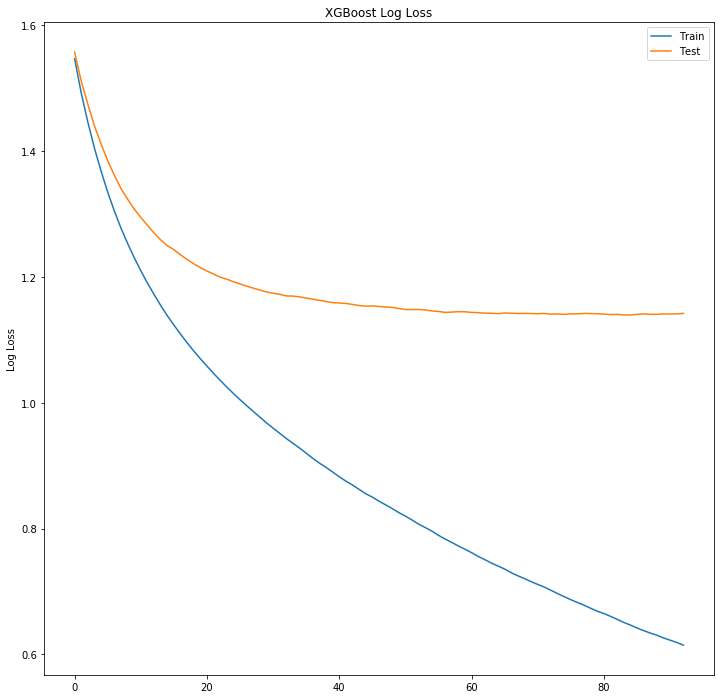

In [13]:
#学習曲線
results = xgb_model.evals_result()
epochs = len(results["validation_0"]["mlogloss"])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["mlogloss"], label="Test")
ax.legend()
pyplot.ylabel("Log Loss")
pyplot.title("XGBoost Log Loss")
pyplot.show()

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 54.73%


In [15]:
# 混同行列の計算
df_accuracy = pd.DataFrame({'true label': y_test,
                            'predicted label': y_pred})
pd.crosstab(df_accuracy['true label'], df_accuracy['predicted label'])

predicted label,lv0,lv1,lv2,lv3,lv4
true label,,,,,
lv0,59,35,1,0,0
lv1,24,286,33,1,1
lv2,10,116,67,0,0
lv3,11,53,22,1,3
lv4,10,22,6,1,9


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         lv0       0.52      0.62      0.56        95
         lv1       0.56      0.83      0.67       345
         lv2       0.52      0.35      0.42       193
         lv3       0.33      0.01      0.02        90
         lv4       0.69      0.19      0.30        48

    accuracy                           0.55       771
   macro avg       0.52      0.40      0.39       771
weighted avg       0.53      0.55      0.49       771



このモデルの目的は、リセールでより高い利益を得られるスニーカーを探すことである。そこで利益が最も大きいフラグlv4の評価指標を見ると、適合率は0.69と比較的高い値を示したが、再現率は0.19と、かなり低い値にとどまっている。今回の問題設定では、lv4のスニーカーをより多く正確に予測することは最優先事項ではないので、再現率の低さは許容することにする。最優先事項はlv4と予測されたスニーカーが実際にlv4である割合を表す適合率で、現に高い値を示している。ただデータ数が少なく、適合率の母数は13であることに注意が必要である。

In [17]:
#AUC
y_test_bi = label_binarize(y_test, classes=['lv0', 'lv1', 'lv2', 'lv3', 'lv4'])
y_pred_bi = label_binarize(y_pred, classes=['lv0', 'lv1', 'lv2', 'lv3', 'lv4'])
auc = roc_auc_score(y_test_bi, y_pred_bi, multi_class="ovo")
print(auc)

0.6268186333326966


当て推量0.5を上回っている

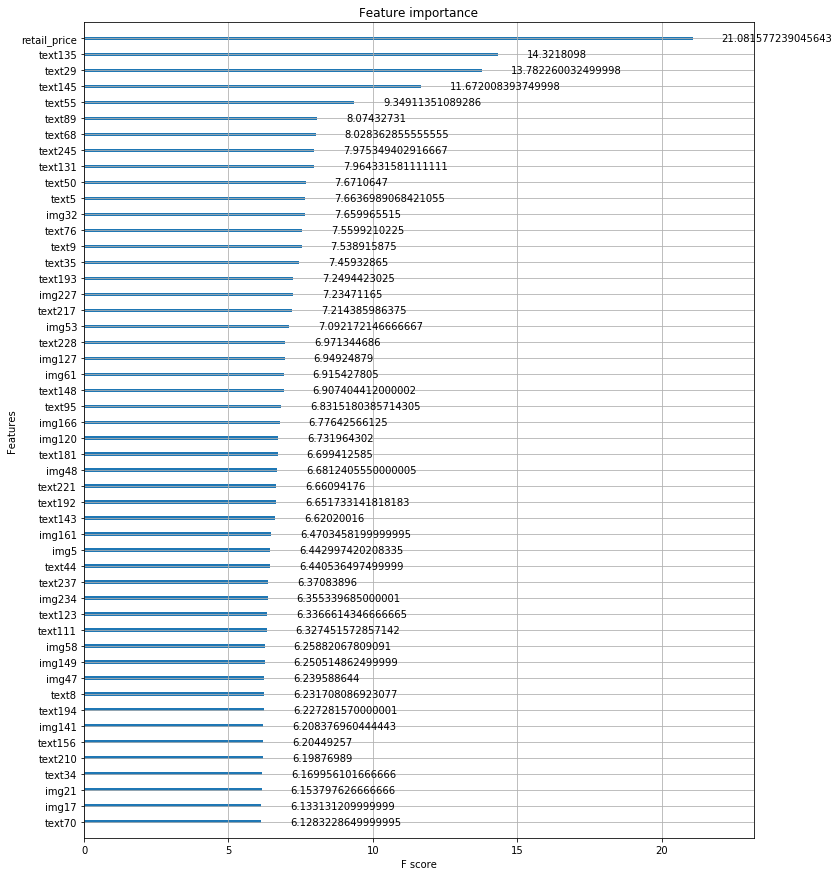

In [18]:
_, ax = plt.subplots(figsize=(12, 15))
xgb.plot_importance(xgb_model, ax=ax, max_num_features=50,importance_type='gain')

やはり定価の特徴量が顕著に効いている

#### pickleモジュールでPythonオブジェクトをシリアライズする

In [19]:
pickle.dump(xgb_model, open(os.path.join('../objects', 'classifier5.pkl'), 'wb'), protocol=4)

## 3クラス分類

In [20]:
text_df_256.columns = list('text' + str(i) for i in range(len(text_df_256.columns)))
img_xception_256_df.columns = list('img' + str(i) for i in range(len(img_xception_256_df.columns)))
df = pd.concat([adidas_final_df[['retail_price', 'avg_sale_price_12_month']], img_xception_256_df, text_df_256], axis=1)
df

,retail_price,avg_sale_price_12_month,img0,img1,img2,img3,img4,img5,img6,img7,...,text246,text247,text248,text249,text250,text251,text252,text253,text254,text255
0,57585.0,19300.0,-4.283783,-6.750264,-5.150335,1.256626,-9.724740,-5.048487,7.188885,5.376353,...,0.0,0.054930,0.014631,0.0,0.023574,0.045781,0.0,0.0,0.015947,0.002259
1,14134.5,20900.0,1.382455,-9.231929,-4.143682,0.357695,3.905091,2.579433,-8.553669,-10.803032,...,0.0,0.055210,0.015369,0.0,0.017529,0.033443,0.0,0.0,0.017639,0.003152
2,20940.0,22900.0,1.673768,-0.246558,-1.221280,-10.127142,-3.121317,0.519163,-2.679033,5.912999,...,0.0,0.052308,0.010773,0.0,0.014470,0.027584,0.0,0.0,0.007615,0.010024
3,16752.0,4700.0,13.290643,-2.184021,-3.324477,2.637169,-4.675468,6.345741,-1.390021,12.048939,...,0.0,0.045357,0.018151,0.0,0.017598,0.031712,0.0,0.0,0.013940,0.007207
4,18846.0,11000.0,0.833021,-11.004178,13.292379,-3.163523,-1.757586,-0.528176,2.310873,-0.791523,...,0.0,0.064967,0.015366,0.0,0.016728,0.031528,0.0,0.0,0.015743,0.000937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,12564.0,5400.0,-2.439531,-3.670244,-6.734210,11.521386,0.397611,-1.654798,-2.403471,-0.727678,...,0.0,0.053601,0.009422,0.0,0.022746,0.042807,0.0,0.0,0.000000,0.005116
3848,10470.0,8600.0,8.248449,12.790409,-7.766125,-10.269954,2.882046,3.910087,-6.728028,5.449539,...,0.0,0.058208,0.013774,0.0,0.019924,0.049637,0.0,0.0,0.011541,0.006723
3849,18846.0,19800.0,9.745172,6.925892,6.317610,-3.153733,0.767988,-10.826612,-9.771851,-6.034394,...,0.0,0.055463,0.002061,0.0,0.021807,0.028284,0.0,0.0,0.008126,0.000000
3850,18846.0,35900.0,-3.907735,-10.250506,4.323690,12.592658,3.593113,-5.303736,-5.119253,-6.489745,...,0.0,0.064246,0.019134,0.0,0.014014,0.043467,0.0,0.0,0.020839,0.009376


#### 利益（リセール価格 - 定価）フラグを追加

- lv0 利益が-2500円未満
- lv1 利益が-2500円以上-2500円未満
- lv2 利益が-2500円以上


この利益フラグを予測する多クラス分類とする。

In [21]:
#3クラス分類

df['profit'] = df['avg_sale_price_12_month'] - df['retail_price']

item0 = df[(df['profit'] < -2500)]
item1 = df[(df['profit'] >= -2500) & (df['profit'] < 2500)]
item2 = df[(df['profit'] >= 2500)]

print('-2500未満: {}個'.format(len(item0)))
print('-2500以上-2500未満: {}個'.format(len(item1)))
print('2500以上: {}個'.format(len(item2)))

df.loc[df['profit'] < -2500, 'profit_flg'] = 'lv0'
df.loc[(df['profit'] >= -2500) & (df['profit'] < 2500), 'profit_flg'] = 'lv1'
df.loc[df['profit'] >= 2500, 'profit_flg'] = 'lv2'

df = df.drop(['avg_sale_price_12_month', 'profit'], axis=1)
df

-2500未満: 2196個
-2500以上-2500未満: 964個
2500以上: 692個


,retail_price,img0,img1,img2,img3,img4,img5,img6,img7,img8,...,text247,text248,text249,text250,text251,text252,text253,text254,text255,profit_flg
0,57585.0,-4.283783,-6.750264,-5.150335,1.256626,-9.724740,-5.048487,7.188885,5.376353,3.990421,...,0.054930,0.014631,0.0,0.023574,0.045781,0.0,0.0,0.015947,0.002259,lv0
1,14134.5,1.382455,-9.231929,-4.143682,0.357695,3.905091,2.579433,-8.553669,-10.803032,6.684401,...,0.055210,0.015369,0.0,0.017529,0.033443,0.0,0.0,0.017639,0.003152,lv2
2,20940.0,1.673768,-0.246558,-1.221280,-10.127142,-3.121317,0.519163,-2.679033,5.912999,-0.021313,...,0.052308,0.010773,0.0,0.014470,0.027584,0.0,0.0,0.007615,0.010024,lv1
3,16752.0,13.290643,-2.184021,-3.324477,2.637169,-4.675468,6.345741,-1.390021,12.048939,4.203515,...,0.045357,0.018151,0.0,0.017598,0.031712,0.0,0.0,0.013940,0.007207,lv0
4,18846.0,0.833021,-11.004178,13.292379,-3.163523,-1.757586,-0.528176,2.310873,-0.791523,-3.335037,...,0.064967,0.015366,0.0,0.016728,0.031528,0.0,0.0,0.015743,0.000937,lv0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,12564.0,-2.439531,-3.670244,-6.734210,11.521386,0.397611,-1.654798,-2.403471,-0.727678,-1.244541,...,0.053601,0.009422,0.0,0.022746,0.042807,0.0,0.0,0.000000,0.005116,lv0
3848,10470.0,8.248449,12.790409,-7.766125,-10.269954,2.882046,3.910087,-6.728028,5.449539,-4.332220,...,0.058208,0.013774,0.0,0.019924,0.049637,0.0,0.0,0.011541,0.006723,lv1
3849,18846.0,9.745172,6.925892,6.317610,-3.153733,0.767988,-10.826612,-9.771851,-6.034394,-9.890096,...,0.055463,0.002061,0.0,0.021807,0.028284,0.0,0.0,0.008126,0.000000,lv1
3850,18846.0,-3.907735,-10.250506,4.323690,12.592658,3.593113,-5.303736,-5.119253,-6.489745,-2.811875,...,0.064246,0.019134,0.0,0.014014,0.043467,0.0,0.0,0.020839,0.009376,lv2


In [22]:
df.to_csv('xception_256_text_256_3classes.csv', index=False)

#### xgboostでモデル構築（scikit-learn API）

In [23]:
X = df.drop('profit_flg', axis=1)
y = df['profit_flg']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20, 
                                                    stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20, 
                                                    stratify = y_train)

In [24]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_model.fit(X_train, y_train, 
              early_stopping_rounds=10, 
              eval_metric="mlogloss", 
              eval_set=eval_set, 
              verbose=False)


y_pred = xgb_model.predict(X_test)

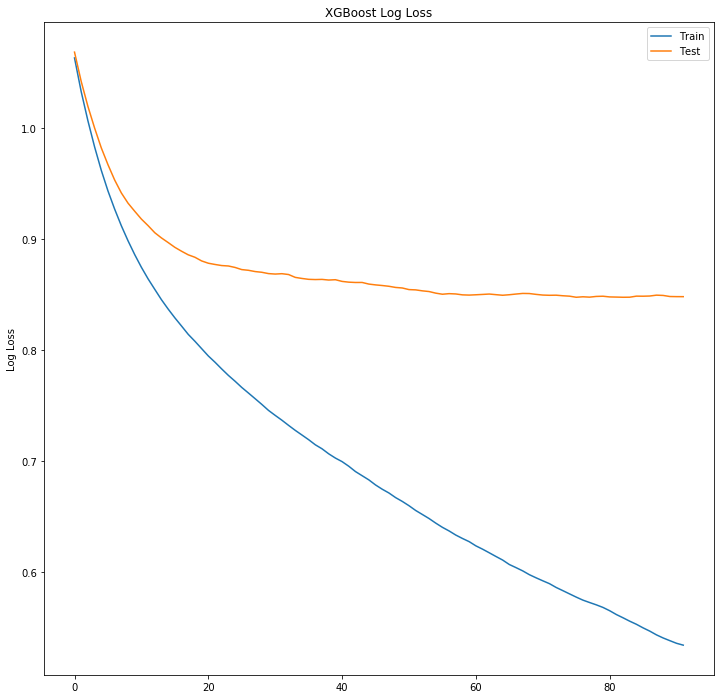

In [25]:
#学習曲線
results = xgb_model.evals_result()
epochs = len(results["validation_0"]["mlogloss"])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["mlogloss"], label="Test")
ax.legend()
pyplot.ylabel("Log Loss")
pyplot.title("XGBoost Log Loss")
pyplot.show()

In [26]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.61%


In [27]:
# 混同行列の計算
df_accuracy = pd.DataFrame({'true label': y_test,
                            'predicted label': y_pred})
pd.crosstab(df_accuracy['true label'], df_accuracy['predicted label'])

predicted label,lv0,lv1,lv2
true label,,,
lv0,406,33,1
lv1,136,54,3
lv2,94,29,15


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         lv0       0.64      0.92      0.75       440
         lv1       0.47      0.28      0.35       193
         lv2       0.79      0.11      0.19       138

    accuracy                           0.62       771
   macro avg       0.63      0.44      0.43       771
weighted avg       0.62      0.62      0.55       771



5クラス分類に比べて全体的に評価指標は向上している。重視している利益が最も大きいフラグlv2の適合率は0.79と高い値を示したが、今回もその割合の母数は19と小さいことには注意が必要。

In [29]:
#AUC

y_test_bi = label_binarize(y_test, classes=['lv0', 'lv1', 'lv2'])
y_pred_bi = label_binarize(y_pred, classes=['lv0', 'lv1', 'lv2'])
auc = roc_auc_score(y_test_bi, y_pred_bi, multi_class="ovo")
print(auc)

0.5837943452277989


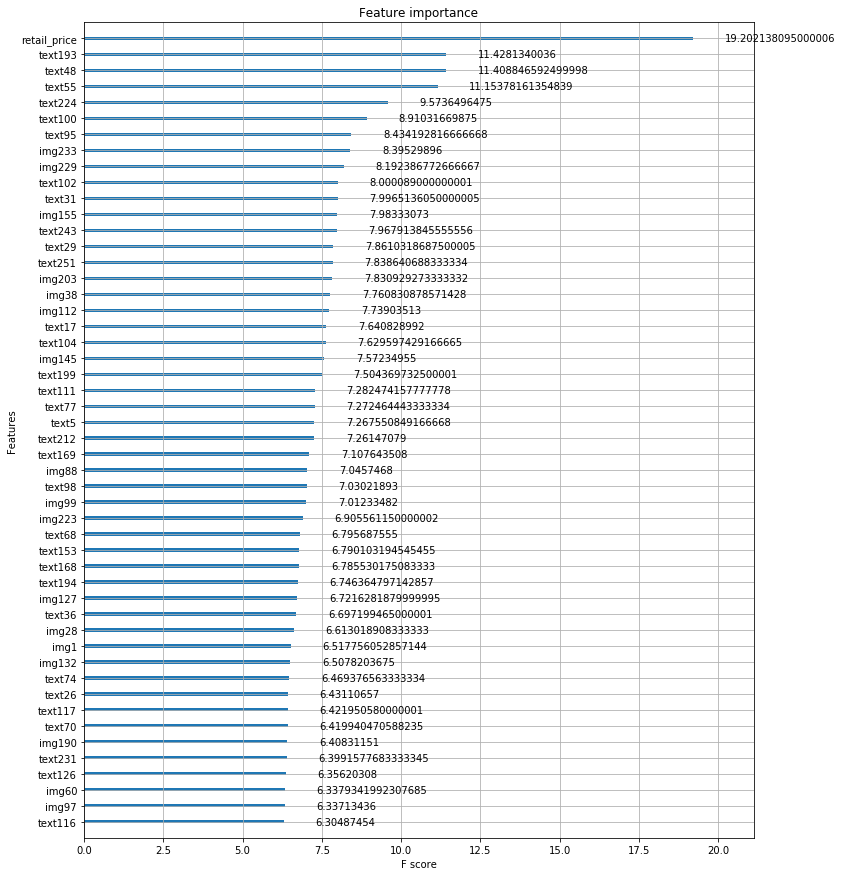

In [30]:
_, ax = plt.subplots(figsize=(12, 15))
xgb.plot_importance(xgb_model, ax=ax, max_num_features=50,importance_type='gain')

In [31]:
pickle.dump(xgb_model, open(os.path.join('../objects', 'classifier3.pkl'), 'wb'), protocol=4)